In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tarfile
import urllib.request
import os
from pathlib import Path
import re
from helpers.dataset_explore import display_model_image, display_model_fragments, display_fragment_image, display_fragment_and_model
from helpers.zookeeper import index_zoo_files, parse_zoo_filename, match_models_to_zoo_files
from helpers.parsers import parse_yuml_model,  inspect_model_yuml_visually
from helpers.stats import compute_model_stats
from helpers.graphs import print_inheritance_hierarchy, draw_inheritance_graph
import networkx as nx

###Dataset Download

Download full dataset (if not present), set up working directory

In [3]:
# Automatically set working dir to the notebook location
base_dir = os.path.dirname(os.path.abspath("__file__"))  # __file__ is undefined in notebooks
print(base_dir)
os.chdir(base_dir)

# Dataset details
url = "https://github.com/songyang-dev/uml-classes-and-specs/releases/download/v1.0.0/dataset.tar.gz"
tar_path = "dataset.tar.gz"
extract_dir = "dataset"

# Download dataset if not already present
if not os.path.exists(tar_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, tar_path)
    print("Download complete.")
else:
    print("Dataset archive already exists. Skipping download.")

# Extract dataset if not already extracted (in 'dataset')
if not os.path.isdir(extract_dir):
    print("Extracting dataset into folder 'dataset/'...")
    os.makedirs(extract_dir, exist_ok=True)
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=extract_dir)  # Extract inside 'dataset'
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

# Count total number of files extracted
file_count = sum(len(files) for _, _, files in os.walk(extract_dir))
print(f"{file_count} files found in '{extract_dir}'.")

zoo_dir = Path(extract_dir) / "zoo"

/Users/piachouaifaty/GitHub/Siemens___Task/uml-classes-and-specs
Dataset archive already exists. Skipping download.
Dataset already extracted.
25878 files found in 'dataset'.


In UML:

        NamedElement
           ▲
     ┌─────┼─────┐
     DataBase Table Column
 
DataBase inherits from NamedElement

Table inherits from NamedElement

Column inherits from NamedElement

The arrow points to the parent. The child is the source, the parent is the target

**Acyclic Directed Inheritance Graphs** based on model.yuml

**Depth**: inheritance depth



In [4]:
zoo_idx = index_zoo_files()

In [5]:
zoo_idx

,file_name,file_path
0,USECASE1_rel12.png,dataset/zoo/USECASE1_rel12.png
1,ODP-CV_rel17.png,dataset/zoo/ODP-CV_rel17.png
2,sbvrEclipse_class317.ecore,dataset/zoo/sbvrEclipse_class317.ecore
3,sbvrEclipse_rel81.plantuml,dataset/zoo/sbvrEclipse_rel81.plantuml
4,J2SE5_rel3.plantuml,dataset/zoo/J2SE5_rel3.plantuml
...,...,...
25839,sbvrOMG_class190.ecore,dataset/zoo/sbvrOMG_class190.ecore
25840,sbvrEclipse_class255.png,dataset/zoo/sbvrEclipse_class255.png
25841,UEMLExtensionDynamicAspects_rel6.plantuml,dataset/zoo/UEMLExtensionDynamicAspects_rel6.p...
25842,ProMarte_class95.png,dataset/zoo/ProMarte_class95.png


In [6]:
dataset_path = Path(extract_dir)

fragments = pd.read_csv(dataset_path / "fragments.csv")
labels = pd.read_csv(dataset_path / "labels.csv")
models = pd.read_csv(dataset_path / "models.csv")


In [7]:
fragments

,kind,number,unique_id,model
0,class,16,256,Agate
1,class,1,662,DoDAF-OV5
2,class,53,799,SysML
3,class,91,43,SCADE
4,class,4,1497,OpenQVT
...,...,...,...,...
8167,rel,24,8168,ProMarte
8168,rel,132,8169,XHTML
8169,rel,39,8170,DoDAF-SV4
8170,rel,70,8171,MSVisio_DatadiagramMLTextFormat


In [8]:
labels

,id,label,fragment_id,in_english,validated
0,355,Key is a class in SimpleRDBMS package,2209,t,t
1,357,A Key is owned by one and only one Table in an...,5053,t,t
2,358,A Key refers to 0 or several opposite foreign ...,5911,t,t
3,361,A Foreign Key refers to one and only one Key i...,7988,t,t
4,27,The metamodel is composed of a Publication cla...,1135,t,t
...,...,...,...,...,...
644,707,There is a class ReuseContract with a relation...,7287,t,t
645,709,A class named Dependency.\r\nThe class has no ...,3430,t,t
646,710,A class Dependency.\r\nThere is a relation fro...,4586,t,t
647,711,There are two classes: CompositeProvider and R...,4790,t,t


In [9]:
models

,name,classes,relations
0,ACG,70,29
1,ACME,16,8
2,ADELFE,19,14
3,ASM,0,0
4,ATL,28,33
...,...,...,...
275,sbvrEclipse,332,185
276,sbvrOMG,193,46
277,useCase,8,5
278,vb,0,0


In [10]:
print(f"Number of model entries: {models.shape[0]}")
print(f"Number of fragment entries : {fragments.shape[0]}")
print(f"Number of label entries: {labels.shape[0]}")


Number of model entries: 280
Number of fragment entries : 8172
Number of label entries: 649


In [11]:
# Class and relation counts from fragments
kind_counts = fragments['kind'].value_counts()
print("\nFragment kinds:")
print(kind_counts)


Fragment kinds:
kind
class    4525
rel      3647
Name: count, dtype: int64


In [12]:
# Join labels to fragments to see what label describes what kind
labeled_fragments = labels.merge(fragments, left_on="fragment_id", right_on="unique_id", how="inner")
labeled_fragments

,id,label,fragment_id,in_english,validated,kind,number,unique_id,model
0,355,Key is a class in SimpleRDBMS package,2209,t,t,class,4,2209,QVT_SimpleRDBMS
1,357,A Key is owned by one and only one Table in an...,5053,t,t,rel,5,5053,QVT_SimpleRDBMS
2,358,A Key refers to 0 or several opposite foreign ...,5911,t,t,rel,6,5911,QVT_SimpleRDBMS
3,361,A Foreign Key refers to one and only one Key i...,7988,t,t,rel,8,7988,QVT_SimpleRDBMS
4,27,The metamodel is composed of a Publication cla...,1135,t,t,class,0,1135,Publication
...,...,...,...,...,...,...,...,...,...
644,707,There is a class ReuseContract with a relation...,7287,t,t,rel,0,7287,UML_withReuseContracts
645,709,A class named Dependency.\r\nThe class has no ...,3430,t,t,class,1,3430,UML_withReuseContracts
646,710,A class Dependency.\r\nThere is a relation fro...,4586,t,t,rel,1,4586,UML_withReuseContracts
647,711,There are two classes: CompositeProvider and R...,4790,t,t,rel,2,4790,UML_withReuseContracts


In [13]:
matched_df, unmatched_files_df, unmatched_models_df = match_models_to_zoo_files(models, zoo_idx)

In [14]:
matched_df

,model,file_name,file_path
0,ACG,ACG_class19.ecore,dataset/zoo/ACG_class19.ecore
1,ACG,ACG_class22.png,dataset/zoo/ACG_class22.png
2,ACG,ACG_class36.png,dataset/zoo/ACG_class36.png
3,ACG,ACG_rel16.plantuml,dataset/zoo/ACG_rel16.plantuml
4,ACG,ACG_rel17.plantuml,dataset/zoo/ACG_rel17.plantuml
...,...,...,...
34014,yUML,yUML_class6.ecore,dataset/zoo/yUML_class6.ecore
34015,yUML,yUML_class2.ecore,dataset/zoo/yUML_class2.ecore
34016,yUML,yUML_class4.plantuml,dataset/zoo/yUML_class4.plantuml
34017,yUML,yUML_class5.plantuml,dataset/zoo/yUML_class5.plantuml


In [15]:
unmatched_files_df

,file_name,file_path
528,ontofarm.html,dataset/zoo/ontofarm.html
531,mlhim2.ecore,dataset/zoo/mlhim2.ecore
722,edas.owl.ecore,dataset/zoo/edas.owl.ecore
758,OpenConf.owl_*.plantuml,dataset/zoo/OpenConf.owl_*.plantuml
853,confious.owl_*.plantuml,dataset/zoo/confious.owl_*.plantuml
...,...,...
24672,BPEL.ecore,dataset/zoo/BPEL.ecore
24788,cmt.owl_*.plantuml,dataset/zoo/cmt.owl_*.plantuml
25203,confOf.owl.plantuml,dataset/zoo/confOf.owl.plantuml
25475,Requirement.yuml,dataset/zoo/Requirement.yuml


In [16]:
#unmatched_models_df
#None

In [17]:
parsed_cols = matched_df["file_name"].apply(lambda fn: pd.Series(parse_zoo_filename(fn), index=["kind", "number", "file_type"]))
matched_df = pd.concat([matched_df, parsed_cols], axis=1)
matched_df

,model,file_name,file_path,kind,number,file_type
0,ACG,ACG_class19.ecore,dataset/zoo/ACG_class19.ecore,class,19.0,ecore
1,ACG,ACG_class22.png,dataset/zoo/ACG_class22.png,class,22.0,png
2,ACG,ACG_class36.png,dataset/zoo/ACG_class36.png,class,36.0,png
3,ACG,ACG_rel16.plantuml,dataset/zoo/ACG_rel16.plantuml,rel,16.0,plantuml
4,ACG,ACG_rel17.plantuml,dataset/zoo/ACG_rel17.plantuml,rel,17.0,plantuml
...,...,...,...,...,...,...
34014,yUML,yUML_class6.ecore,dataset/zoo/yUML_class6.ecore,class,6.0,ecore
34015,yUML,yUML_class2.ecore,dataset/zoo/yUML_class2.ecore,class,2.0,ecore
34016,yUML,yUML_class4.plantuml,dataset/zoo/yUML_class4.plantuml,class,4.0,plantuml
34017,yUML,yUML_class5.plantuml,dataset/zoo/yUML_class5.plantuml,class,5.0,plantuml


In [18]:
yuml_df = matched_df[
    (matched_df["file_type"] == "yuml") &
    (matched_df["kind"] == "full")
].copy()

Models with .yuml: 280
Models missing .yuml: 0


In [20]:
model_name = "RelationalDBSchema"
yuml_file = yuml_df[yuml_df["model"] == model_name].iloc[0]["file_path"]

classes, inheritance, associations = parse_yuml_model(yuml_file, verbose=False)

#print("Classes:", classes)
#print("Inheritance:", inheritance)
#print("Associations:", associations)

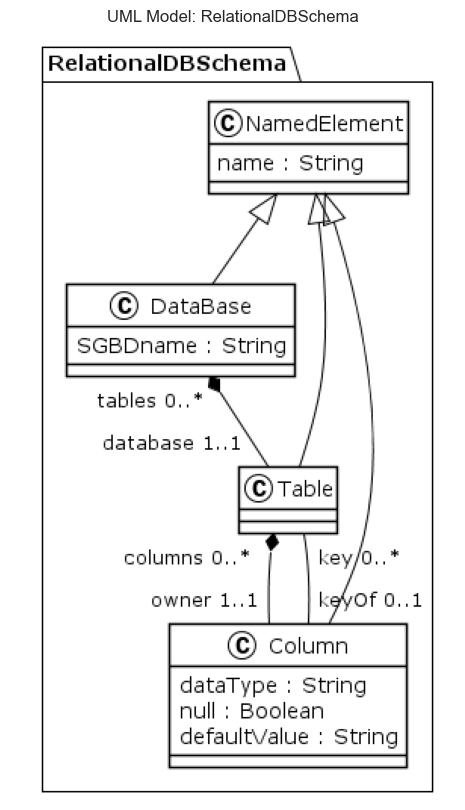

In [21]:
display_model_image("RelationalDBSchema")

In [22]:
classes, inheritance, associations = parse_yuml_model(
    yuml_df[yuml_df["model"] == "RelationalDBSchema"].iloc[0]["file_path"]
)

print_inheritance_hierarchy(inheritance)


Parsing file: dataset/zoo/RelationalDBSchema.yuml
--------------------------------------------------

Line 0: [NamedElement|+name:String],
 Raw class tokens: ['NamedElement|+name:String']
 Normalized class names: ['NamedElement']
 Skipping line: Not a binary relation.

Line 1: [DataBase|+SGBDname:String],
 Raw class tokens: ['DataBase|+SGBDname:String']
 Normalized class names: ['DataBase']
 Skipping line: Not a binary relation.

Line 2: [Column|+dataType:String; +null:Boolean; +defaultValue:String],
 Raw class tokens: ['Column|+dataType:String; +null:Boolean; +defaultValue:String']
 Normalized class names: ['Column']
 Skipping line: Not a binary relation.

Line 3: [DataBase]++database 1-tables *>[Table],
 Raw class tokens: ['DataBase', 'Table']
 Normalized class names: ['DataBase', 'Table']
 Detected COMPOSITION: DataBase ++ Table

Line 4: [Table]++owner 1-columns *>[Column],
 Raw class tokens: ['Table', 'Column']
 Normalized class names: ['Table', 'Column']
 Detected COMPOSITION: Ta

Inspecting .yuml: dataset/zoo/Java-20040316.yuml

Classes (9): ['ClassFeature', 'ClassMember', 'FeatureParameter', 'Field', 'JavaClass', 'JavaElement', 'Method', 'Package', 'PrimitiveType']
Inheritance Edges (8): [('ClassFeature', 'JavaElement'), ('ClassMember', 'ClassFeature'), ('Field', 'ClassMember'), ('JavaClass', 'ClassFeature'), ('Method', 'ClassMember'), ('Package', 'JavaElement'), ('PrimitiveType', 'JavaClass'), ('FeatureParameter', 'ClassFeature')]
Associations (5): [('ClassMember', 'JavaClass', 'aggregation'), ('JavaClass', 'ClassMember', 'composition'), ('JavaClass', 'FeatureParameter', 'aggregation'), ('Method', 'FeatureParameter', 'composition'), ('Package', 'JavaClass', 'composition')]

Inheritance Hierarchy:

Building inheritance graph...
Original edges (child --> parent):
  ClassFeature → JavaElement
  ClassMember → ClassFeature
  Field → ClassMember
  JavaClass → ClassFeature
  Method → ClassMember
  Package → JavaElement
  PrimitiveType → JavaClass
  FeatureParameter 

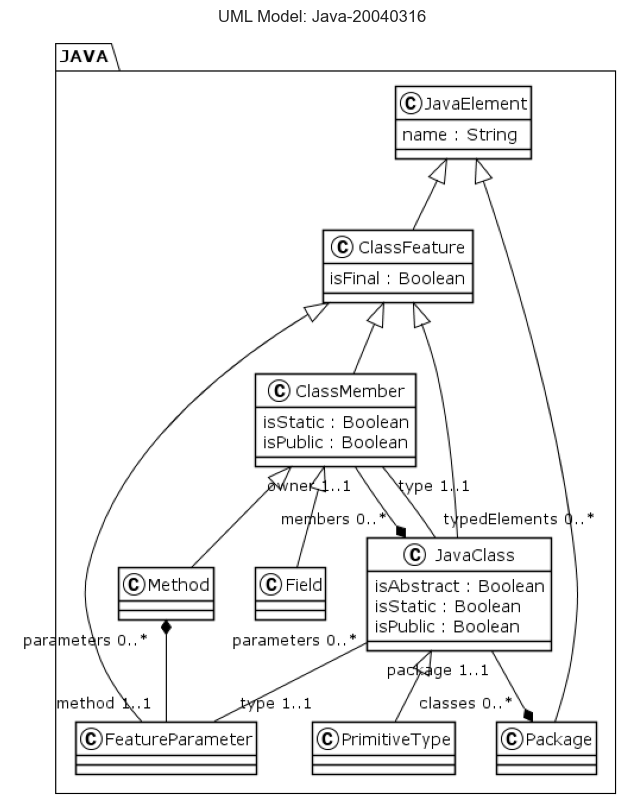


Inheritance Hierarchy:


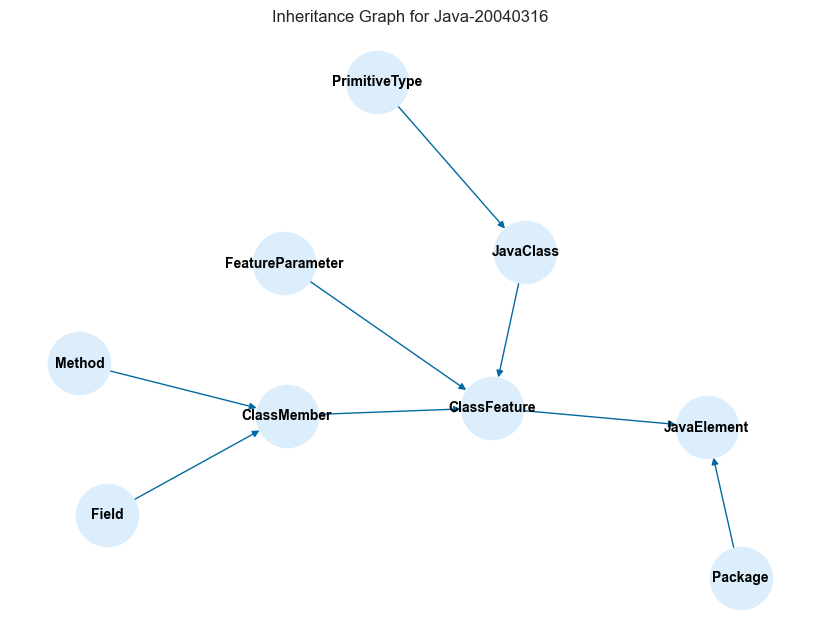

In [23]:
inspect_model_yuml_visually("Java-20040316", yuml_df)

#ACME
#Good example: "Java-20040316"

In [24]:
result = compute_model_stats("RelationalDBSchema", yuml_df)
result

{'model': 'RelationalDBSchema',
 'num_classes': 4,
 'num_inheritance': 3,
 'num_associations': 3,
 'association_types': {'composition': 2, 'aggregation': 1},
 'num_blocks': 10,
 'tree_depth': 1,
 'most_frequent_label': 'inheritance'}

Inspecting .yuml: dataset/zoo/RelationalDBSchema.yuml

Classes (4): ['Column', 'DataBase', 'NamedElement', 'Table']
Inheritance Edges (3): [('DataBase', 'NamedElement'), ('Table', 'NamedElement'), ('Column', 'NamedElement')]
Associations (3): [('DataBase', 'Table', 'composition'), ('Table', 'Column', 'composition'), ('Table', 'Column', 'aggregation')]

Inheritance Hierarchy:

Building inheritance graph...
Original edges (child --> parent):
  DataBase → NamedElement
  Table → NamedElement
  Column → NamedElement

Reversing graph for hierarchy traversal (parent --? child)...

[INFO] Detected hierarchy roots (no parents): ['NamedElement']

=== Inheritance Tree Root: NamedElement ===
↳ NamedElement
NamedElement has children: ['DataBase', 'Table', 'Column']
  ↳ DataBase
  ↳ Table
  ↳ Column

UML Diagram Image: dataset/zoo/RelationalDBSchema.png


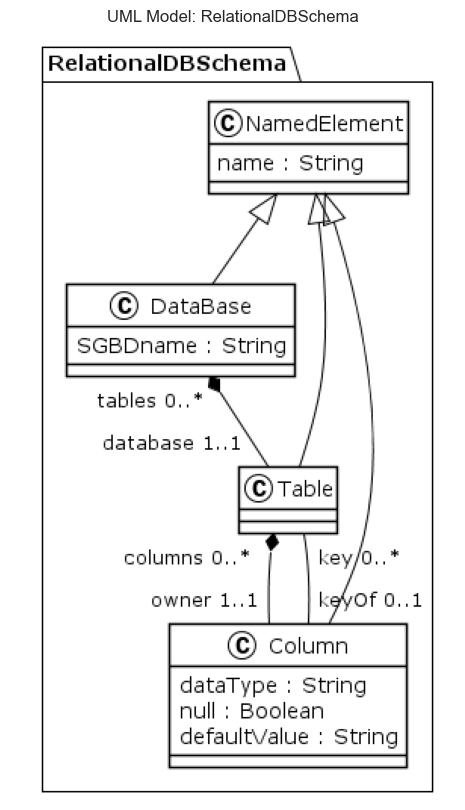


Inheritance Hierarchy:


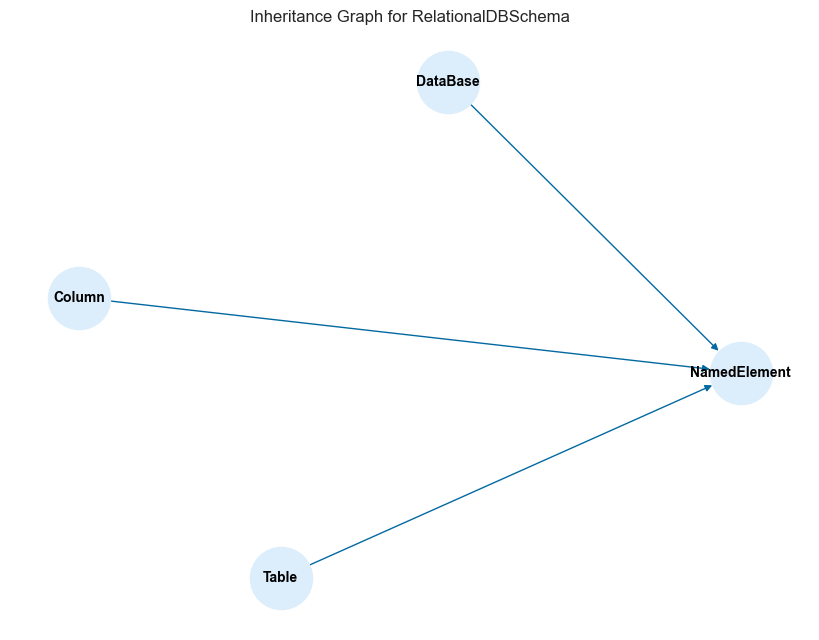

In [26]:
inspect_model_yuml_visually("RelationalDBSchema", yuml_df)


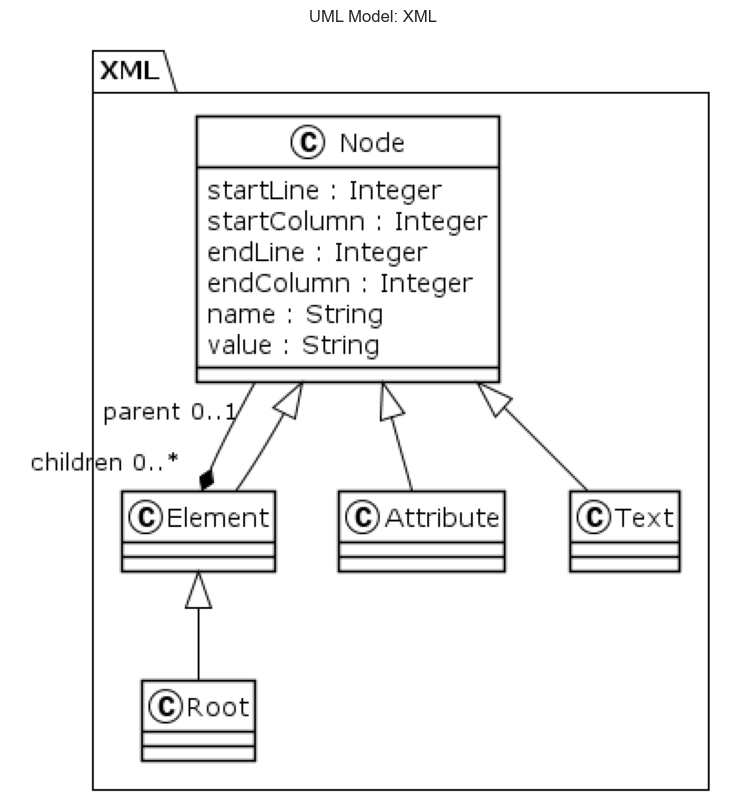

In [25]:
display_model_image("XML")

In [27]:
num_blocks = len(classes) + len(inheritance) + len(associations)

In [28]:
#fragment_id = 7349
#display_fragment_and_model(fragment_id=7349, fragments_df=fragments)

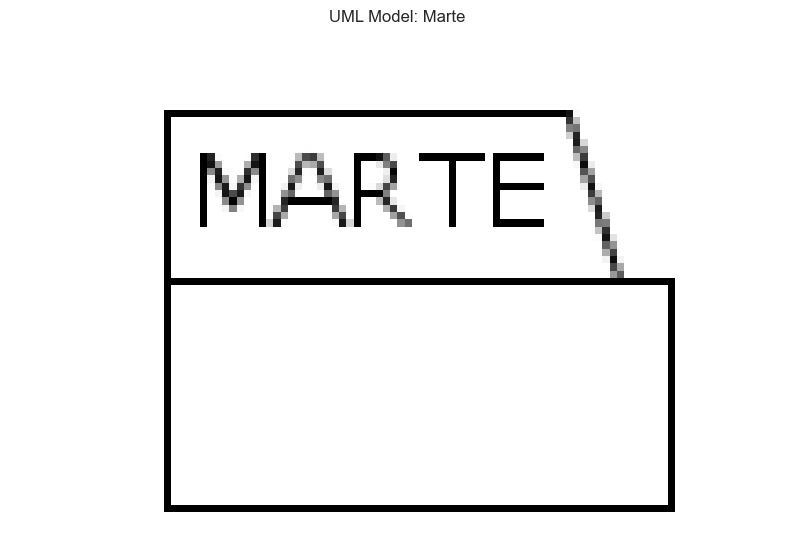

In [31]:
display_model_image("Marte")

--------------------------------------------------
Fragment number: 6
Fragment kind: class
Fragment ID: 61
Fragment image path: dataset/zoo/Make_class6.png


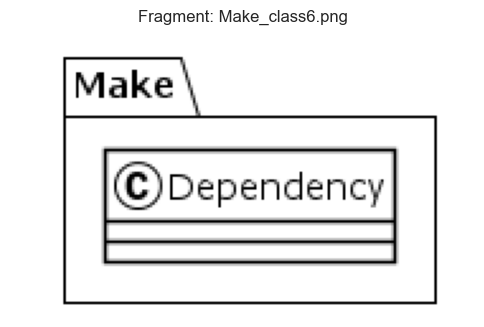

--------------------------------------------------
Fragment number: 1
Fragment kind: class
Fragment ID: 259
Fragment image path: dataset/zoo/Make_class1.png


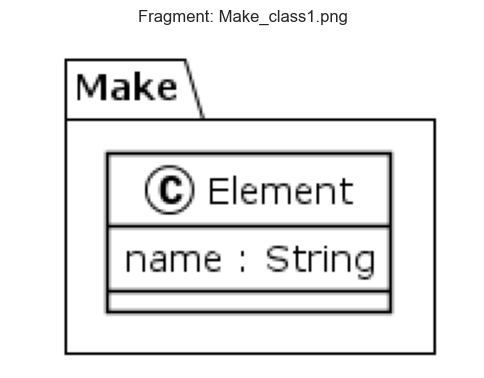

--------------------------------------------------
Fragment number: 2
Fragment kind: class
Fragment ID: 928
Fragment image path: dataset/zoo/Make_class2.png


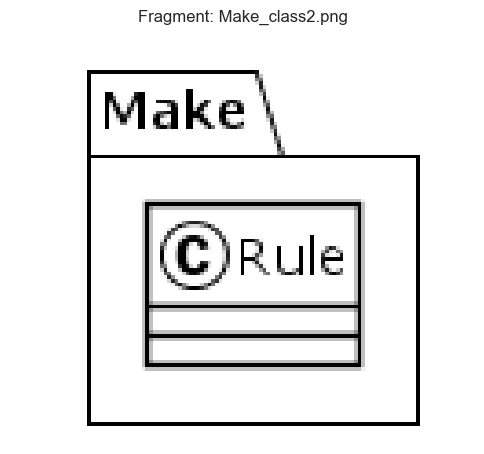

--------------------------------------------------
Fragment number: 8
Fragment kind: class
Fragment ID: 909
Fragment image path: dataset/zoo/Make_class8.png


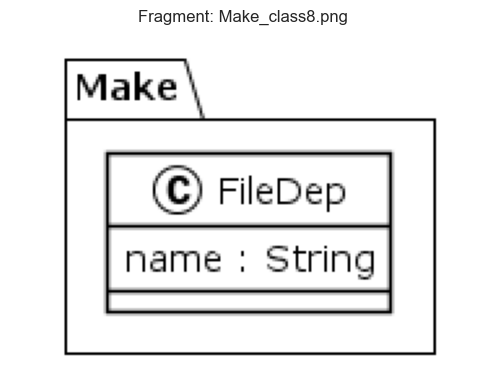

--------------------------------------------------
Fragment number: 5
Fragment kind: class
Fragment ID: 1829
Fragment image path: dataset/zoo/Make_class5.png


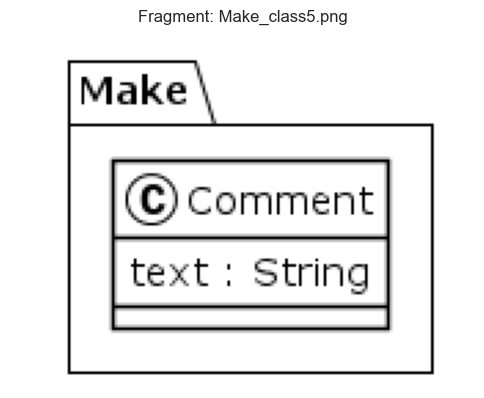

--------------------------------------------------
Fragment number: 4
Fragment kind: class
Fragment ID: 3244
Fragment image path: dataset/zoo/Make_class4.png


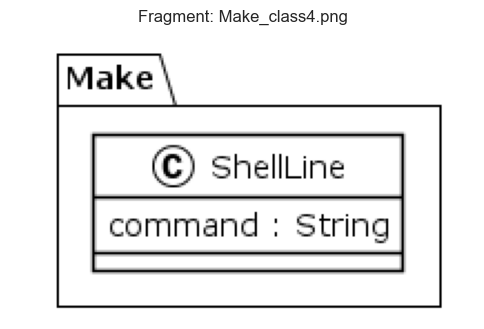

--------------------------------------------------
Fragment number: 7
Fragment kind: class
Fragment ID: 3542
Fragment image path: dataset/zoo/Make_class7.png


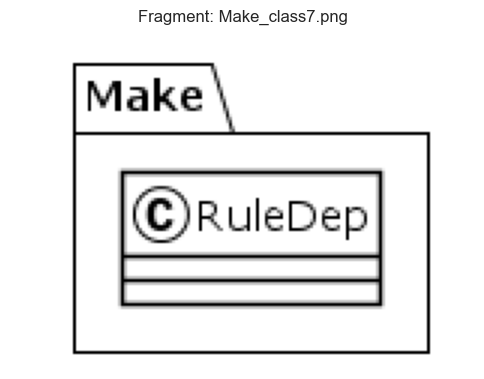

--------------------------------------------------
Fragment number: 2
Fragment kind: rel
Fragment ID: 4941
Fragment image path: dataset/zoo/Make_rel2.png


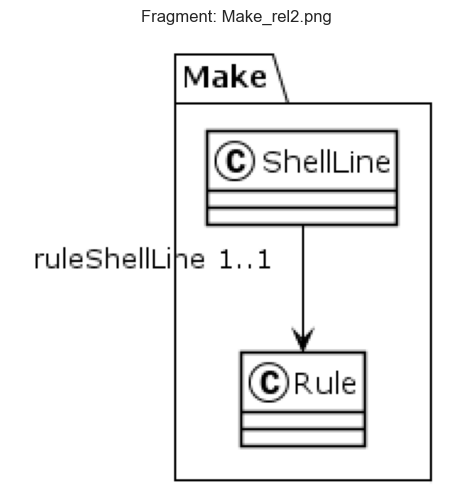

--------------------------------------------------
Fragment number: 0
Fragment kind: rel
Fragment ID: 5340
Fragment image path: dataset/zoo/Make_rel0.png


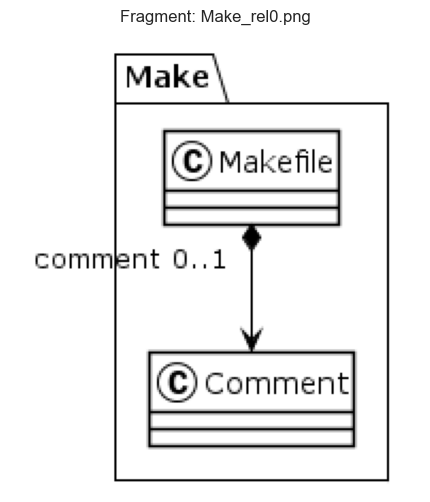

--------------------------------------------------
Fragment number: 1
Fragment kind: rel
Fragment ID: 6612
Fragment image path: dataset/zoo/Make_rel1.png


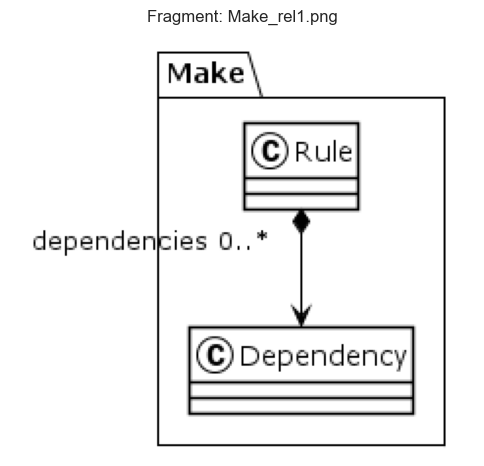

--------------------------------------------------
Fragment number: 3
Fragment kind: rel
Fragment ID: 8019
Fragment image path: dataset/zoo/Make_rel3.png


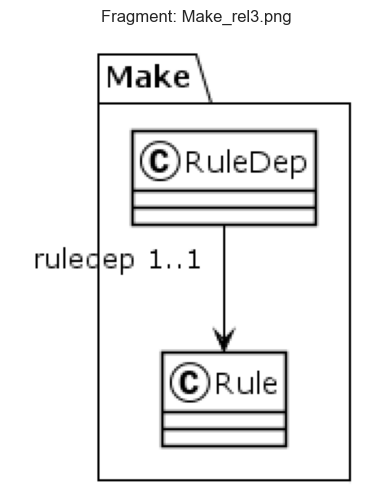

--------------------------------------------------
Fragment number: 0
Fragment kind: class
Fragment ID: 101
Fragment image path: dataset/zoo/Make_class0.png


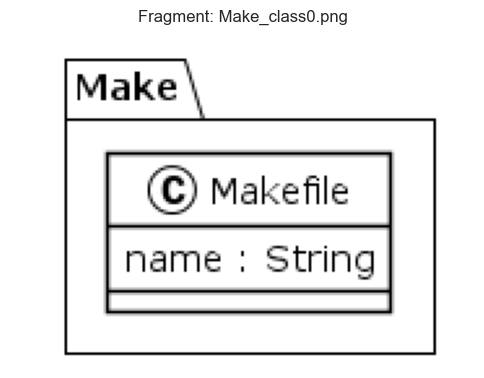

--------------------------------------------------
Fragment number: 3
Fragment kind: class
Fragment ID: 106
Fragment image path: dataset/zoo/Make_class3.png


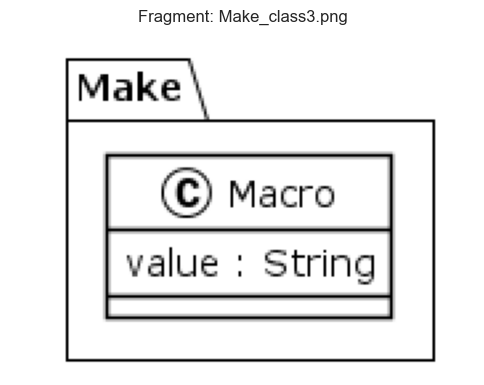

In [27]:
display_model_fragments("Make", fragments)

In [27]:
models = yuml_df["model"].unique()

all_stats = []
for model_name in models:
    try:
        stats = compute_model_stats(model_name, yuml_df)
        all_stats.append(stats)
    except ValueError as e:
        print(f"[WARNING] Skipping {model_name}: {e}")

stats_df = pd.DataFrame(all_stats)
stats_df


,model,num_classes,num_inheritance,num_associations,association_types,num_blocks,tree_depth,most_frequent_label
0,ACG,71,71,39,"{'composition': 37, 'unknown': 2}",181,4,inheritance
1,ACME,16,12,10,{'composition': 10},38,2,inheritance
2,ADELFE,19,9,12,"{'composition': 6, 'unknown': 3, 'aggregation'...",40,1,inheritance
3,ASM,37,35,44,"{'composition': 42, 'aggregation': 1, 'unknown...",116,3,composition
4,ATL,84,83,69,"{'composition': 62, 'aggregation': 5, 'unknown...",236,5,inheritance
...,...,...,...,...,...,...,...,...
275,sbvrEclipse,332,195,344,"{'aggregation': 38, 'unknown': 305, 'compositi...",871,8,unknown
276,sbvrOMG,193,195,66,"{'aggregation': 38, 'unknown': 27, 'compositio...",454,8,inheritance
277,useCase,8,3,7,"{'composition': 3, 'aggregation': 2, 'unknown'...",18,1,composition
278,vb,67,65,74,"{'composition': 71, 'unknown': 3}",206,5,composition


Inspecting .yuml: dataset/zoo/WikiTable.yuml

Classes (5): ['Caption', 'Cell', 'LocatedElement', 'Row', 'Table']
Inheritance Edges (4): [('Table', 'LocatedElement'), ('Caption', 'LocatedElement'), ('Row', 'LocatedElement'), ('Cell', 'LocatedElement')]
Associations (3): [('Table', 'Caption', 'composition'), ('Table', 'Row', 'composition'), ('Row', 'Cell', 'composition')]

Inheritance Hierarchy:

Building inheritance graph...
Original edges (child --> parent):
  Table → LocatedElement
  Caption → LocatedElement
  Row → LocatedElement
  Cell → LocatedElement

Reversing graph for hierarchy traversal (parent --? child)...

[INFO] Detected hierarchy roots (no parents): ['LocatedElement']

=== Inheritance Tree Root: LocatedElement ===
↳ LocatedElement
LocatedElement has children: ['Table', 'Caption', 'Row', 'Cell']
  ↳ Table
  ↳ Caption
  ↳ Row
  ↳ Cell

UML Diagram Image: dataset/zoo/WikiTable.png


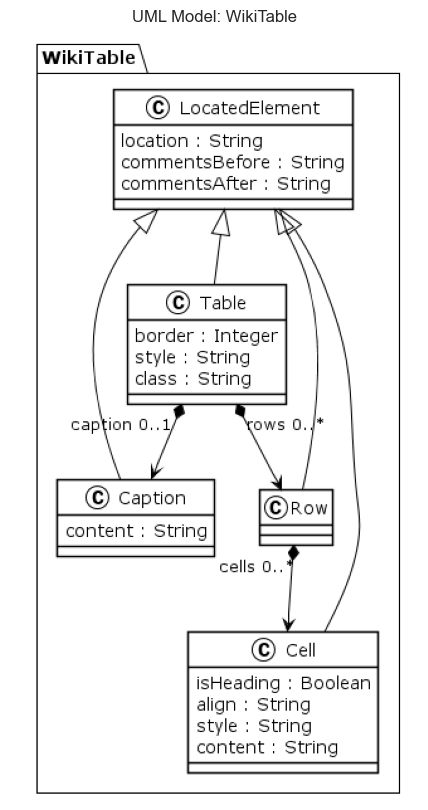


Inheritance Hierarchy:


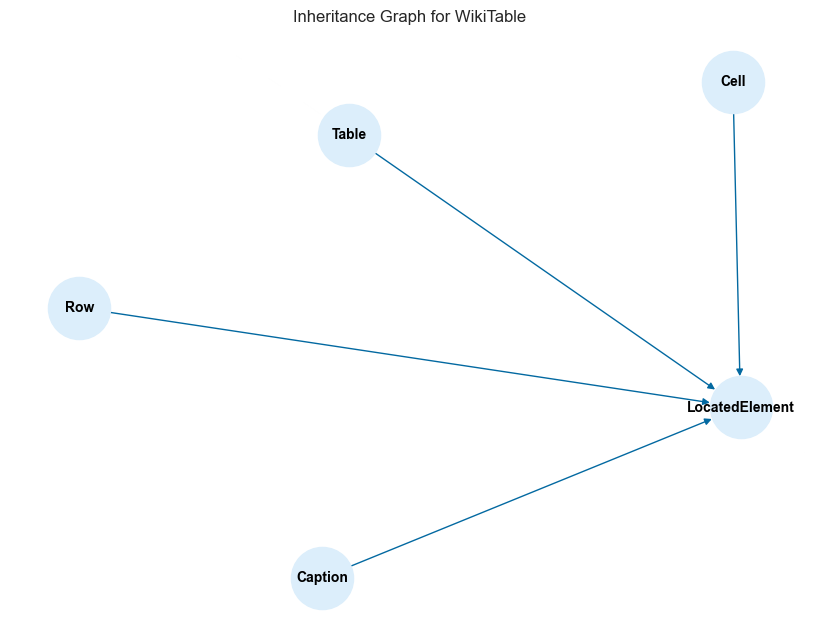

In [30]:
inspect_model_yuml_visually("WikiTable", yuml_df)